## Ordinal Logistic Regression using Iris Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

In [2]:
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data,
                      columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df


iris = sklearn_to_df(datasets.load_iris())
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
def normalize(df):
    '''Feature scaling using mean normalization.
    Scales feature values between -1 and 1.'''

    for column in df.columns[:-1]:
        df[column] = (df[column] - df[column].mean()) / df[column].std()
    return df


normalized_iris = normalize(iris)
normalized_iris.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,-0.897674,1.015602,-1.335752,-1.311052,0
1,-1.139200,-0.131539,-1.335752,-1.311052,0


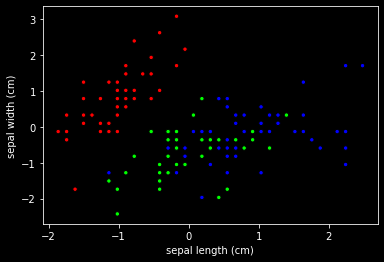

((120, 4), (30, 4), (120,), (30,))

In [4]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

X = normalized_iris.drop(columns='target')
y = normalized_iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure()
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap, edgecolor='k', s=20)
plt.xlabel(f"{X.columns[0]}")
plt.ylabel(f"{X.columns[1]}")
plt.show()
X_train.shape, X_test.shape, y_train.shape, y_test.shape


### Equations

#### Hypothesis & Prediction / Polynomial Decision Boundary
The hypothesis is updated using gradient descent until it is optimized to fit the polynomial hyperplane as a decision boundary that best separates the data into classes. This optimal hyperplane (or curve) is the model's prediction for the decision boundary for unseen points. $ x_0=1$. 

$y_{pred}=\hat{y}=h_{\vec{\theta}}(x)= \frac{1}{1 + e^{-\vec{\theta^{T}} \vec{x}}}$

where $\vec{\theta^{T}} \vec{x} = \theta_0 x_0+\theta_1 x_1+...+\theta_n x_n$

$\vec{\theta}$ is the vector of weights and $\vec{x}$ is the vector of features.

Larger magnitude weights indicate the feature has more say in the prediction curve.

$\vec{\theta} = \begin{bmatrix} 
\theta_0 & \theta_1 & ... & \theta_n
\end{bmatrix},   \vec{x} = \begin{bmatrix}
x_0 & x_1 & ... & x_n
\end{bmatrix} $ 

$\vec{x} \cdot \vec{\theta} =  \vec{\theta} \cdot \vec{x} = \vec{\theta^{T}} \vec{x} = \begin{bmatrix}
\theta_0\\
\theta_1\\
\vdots\\
\theta_n
\end{bmatrix} \begin{bmatrix}
x_0 & x_1 & ... & x_n
\end{bmatrix} $


#### Cost Function
$J(\vec{\theta})=-\frac{1}{m}\sum_{i=1}^{m} y^{(i)}(log (h_{\vec{\theta}}(x^{(i)}))+ (1-y^{(i)}) log (1 - h_{\vec{\theta}}(x^{(i)}))$


#### Gradient Descent
Repeat updating each theta parameter for all $j = 0, 1, ..., n$

$\theta_j:=\theta_j-\alpha(\frac{\partial J(\vec{\theta})}{\partial \theta_j}) = \theta_j-\frac{\alpha}{m}\sum_{i=1}^{m}(h_{\vec{\theta}}(x^{(i)})-y^{(i)})x_{j}^{(i)}$


In [5]:
class VanillaLogisticRegression:
    def __init__(self, alpha=0.001, epochs=5000) -> None:
        self.alpha = alpha
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.losses = []

    def cost_function_andrew_ng(self, X, y, y_pred):
        '''Returns the accumulated loss. This is not used during the learning process, but may be 
        used to visualize the loss.'''
        m = X.shape[0]  # m = number of samples
        return - np.sum(y * np.log(y_pred + np.full_like(y_pred, epsilon, dtype=float)) + (np.ones_like(y) - y) * (np.log(np.ones_like(y_pred) - y_pred + np.full_like(y_pred, epsilon, dtype=float)))) / m

    # def cost_function_mse(self, y, y_pred):
    #     '''Returns the Mean Squared Error (MSE). This is not used during the learning process, but may be 
    #     used to visualize the loss.'''
    #     return np.mean((y - y_pred) ** 2)

    def get_losses(self):
        return self.losses

    def reset_losses(self):
        self.losses = []

    def predict(self, X):
        '''Starts as a sequence of hypotheses, ends as the prediction
        Output: classificaton prediciton vector used for measuring accuracy
        '''
        y_prediction = self.sigmoid(X.dot(self.weights) + self.bias)
        y_prediction_class = np.array([1 if i > 0.5 else 0 for i in y_prediction])
        return y_prediction_class

    def sigmoid(self, x):
        '''
        Input: pre-sigmoid prediction vector
        Output: post-sigmoid prediction vector
        '''
        return 1 / (1 + np.exp(-x))

    def gradient_descent(self, X, y):
        '''The cost function, J(theta) should decrease after every iteration.'''
        m = X.shape[0]  # m = number of samples
        for _ in range(self.epochs):
            y_pred = self.predict(X)
            self.weights -= self.alpha / m * (y_pred - y).dot(X)
            self.bias -= self.alpha / m * np.sum(y_pred - y)
            self.losses.append(self.cost_function_andrew_ng(X, y, y_pred))
            
    def fit(self, X, y):
        '''trains the model'''
        n = X.shape[1]  # n = number of features
        self.weights = np.zeros(n) # initialize weights
        self.bias = 0 # initialize bias
        self.gradient_descent(X, y)




## Splitting the Data and Model Performance Evaluation

### 80-20 Random Split

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%reload_ext autoreload
%autoreload 2

model = VanillaLogisticRegression(alpha=0.001, epochs=600)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
loss = model.cost_function_andrew_ng(X_test, y_test, y_pred)
y_pred_line = model.predict(X)
losses = model.get_losses()

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

print(f'Loss: {loss :.3f}, accuracy score: {accuracy(y_test, y_pred) :.3f}')

fig = plt.figure()
plt.title("Loss vs Epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.plot(losses[2:], color="y", linewidth=1, label="Loss")
plt.legend()
plt.show()


NameError: name 'epsilon' is not defined

### Cross Validation

In [ ]:
from sklearn.model_selection import KFold, LeavePOut

def train_test_cross_validation(model, X, y, cross_validator=KFold, k=5, p=2):
    '''Returns the optimal model'''
    optimal_model = None
    optimal_model_loss = float('inf')
    
    if cross_validator == KFold:
        cv = KFold(n_splits=k, shuffle=True)
    else:
        cv = LeavePOut(p=p)

    losses = []

    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        loss = model.cost_function_andrew_ng(X_test, y_test, y_pred)

        if loss < optimal_model_loss:
            optimal_model = model
            optimal_model_loss = loss
            losses = model.get_losses()

        model.reset_losses()
        
    return optimal_model, losses


##### K-Fold

Loss: 0.101, accuracy score: 0.991


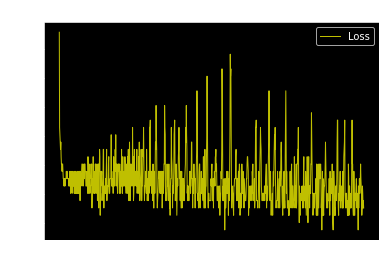

In [ ]:
model = VanillaLogisticRegression(alpha=0.001, epochs=1000)
optimal_model, losses = train_test_cross_validation(model, X, y, cross_validator=KFold, k=5)
y_pred = optimal_model.predict(X_test)
loss = optimal_model.cost_function_andrew_ng(X_test, y_test, y_pred)

print(f'Loss: {loss :.3f}, accuracy score: {accuracy(y_test, y_pred) :.3f}')

y_pred_line = optimal_model.predict(X)

fig = plt.figure()
plt.title("Loss vs Epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.plot(losses[2:], color="y", linewidth=1, label="Loss")
plt.legend()
plt.show()


##### Leave P Out 
This is ideal for smaller datasets because it tests all permutations of test sets of size p, which can take a while to compute.

In [ ]:
# model = VanillaLogisticRegression(alpha=0.001, epochs=5000)
# optimal_model, losses = train_test_cross_validation(model, X, y, cross_validator=LeavePOut, p=2)
# y_pred = optimal_model.predict(X_test)
# loss = optimal_model.cost_function_andrew_ng(X_test, y_test, y_pred)

# print(f'Loss: {loss :.3f}, r2 score: {r2_score(y_test, y_pred) :.3f}')

# y_pred_line = optimal_model.predict(X)

# fig = plt.figure()
# plt.title("Loss vs Epochs")
# plt.ylabel("Loss")
# plt.xlabel("Epochs")
# plt.plot(losses, color="y", linewidth=1, label="Loss")
# plt.legend()
# plt.show()


### Sklearn - Logistic Regression Comparison


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
y_prediction = model.predict(X_test)
model.intercept_, model.coef_
print(f'accuracy score: {accuracy(y_test, y_pred) :.3f}')


accuracy score: 0.991
